In [113]:
using PyPlot
using JuMP, Ipopt
using Random
using Distributions

Random.seed!(3);

In [114]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

include("../src/stochastic_emissions.jl");

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams");
rcParams["lines.linestyle"] = "-";

Solve_Succeeded

Response to variability in baseline emissions
Solve_Succeeded
Solve_Succeeded
NPV: 117.29562749998544 - 127.24848518973687 = -9.952857689751426
T = 1.9209555781839616 to 2.000000001354609
Solve_Succeeded
Solve_Succeeded
NPV: 131.2484331948075 - 117.66228913743379 = 13.586144057373701
T = 2.1587648054793207 to 2.000000015897798

Response to higher geoengineering costs
Solve_Succeeded
Solve_Succeeded
NPV: 142.05058634745117 - 153.08878440393892 = -11.038198056487744
T = 2.0000000013285995 to 2.000000001327212
Cost overuns: 2.6251815734962634
Solve_Succeeded
Solve_Succeeded
NPV: 112.35594388414258 - 122.49237371506025 = -10.136429830917677
T = 2.000000001327212 to 2.000000014738621
Cost overuns: -0.28943641804013515

Response to higher climate sensitivity
Solve_Succeeded
Solve_Succeeded
NPV: 135.0971114047255 - 127.24848518973687 = 7.848626214988627
T = 2.107324199761498 to 2.000000001424281
Solve_Succeeded
Solve_Succeeded
NPV: 143.59843160284123 - 135.540010335087 = 8.05

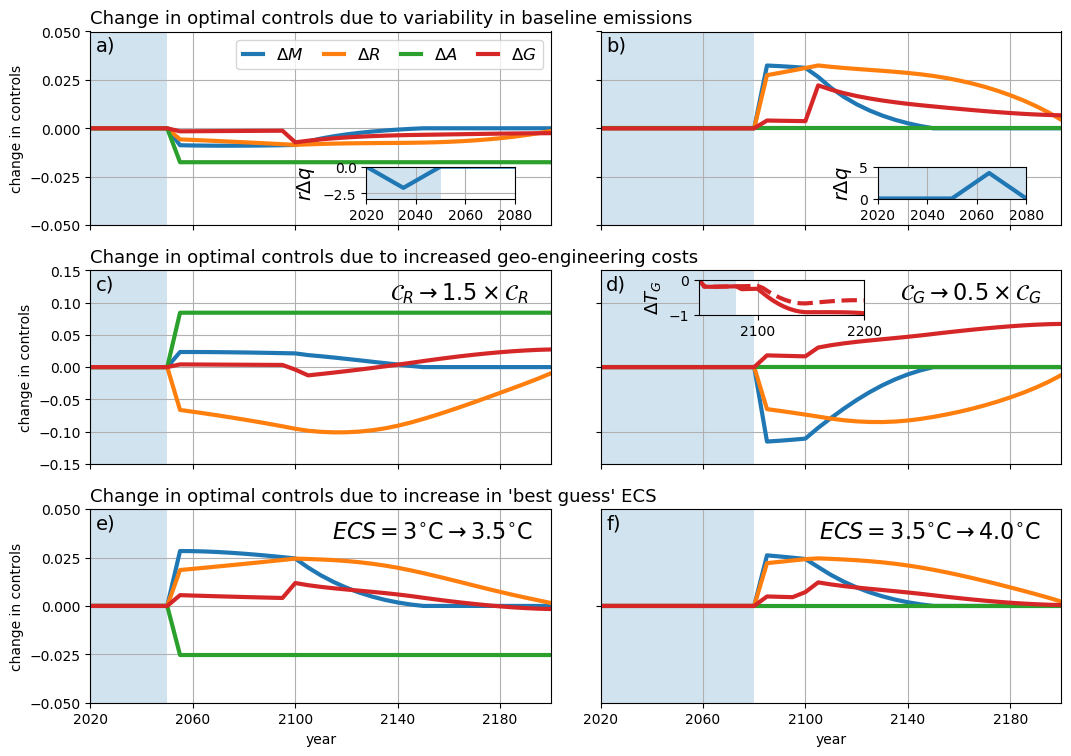


Solve_Succeeded
NPV: 522.100555107992 - 104.62515350066543 = 417.4754016073266
T = 2.398686644420261 to 2.33373974453731


In [125]:
model = ClimateModel();
optimize_controls!(model);

Δt = 30.
Δq_samples = [-2., 4.]/model.physics.r

ensemble = Dict()
ensemble[string(Int64(model.present_year))] = deep_copy(model);

fig = figure(figsize=(11,7.5))
# fig.add_subplot(4,length(Δq_samples),1)
# plot_controls(model)
# legend(loc="upper right")
# xlabel("")
# locs, labels = xticks()
# xticks(locs, labels=[])
# title("")

# fig.add_subplot(4,length(Δq_samples),2)
# plot_emissions(model)
# xlabel("")
# locs, labels = xticks()
# xticks(locs, labels=[])
# title("")

control_dict = Dict()
model_dict = Dict()

ylims = [-0.15, 0.15]

print("\nResponse to variability in baseline emissions\n")
previous_year = deepcopy(model.present_year)
for (n, Δq) in enumerate(Δq_samples)
    control_name = deepcopy(string(Int64(model.present_year + Δt), "_control"))

    # optimize before adding emissions
    control = deep_copy(model)
    control_dict[n] = deep_copy(model)
    step_forward!(control, Δt)
    mcontrol = optimize_controls!(control);
    add_emissions_bump!(control, Δt, Δq, present_year = control.present_year - Δt)
    ensemble[control_name] = control
    
    # optimize after adding emissions
    add_emissions_bump!(model, Δt, Δq)
    step_forward!(model, Δt)
    
    NPV_old = deepcopy(discounted_total_control_cost(model))
    maxT_old = deepcopy(maximum(δT_adapt(model)))
    
    m = optimize_controls!(model);
    model_dict[n] = deep_copy(model)

    NPV_revised = discounted_total_control_cost(model)
    maxT_revised = maximum(δT_adapt(model))
    NPV_diff = NPV_revised - NPV_old
    print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
    print("T = $maxT_old to $maxT_revised\n")

    # Plotting
    fig.add_subplot(3, length(Δq_samples), n)
    fill_between([2020, model.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
    plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
    plot(model.domain, model.controls.remove .- control.controls.remove)
    plot(model.domain, model.controls.adapt .- control.controls.adapt)
    plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
    xlim([2020, 2200])
    ylim(ylims ./ 3.)
    xlabel("")
    ylabel("")
    locs, labels = xticks()
    xticks(locs, labels=[])
    locs, labels = yticks(-0.05:0.025:0.05)
    if n==1
        ylabel("change in controls");
        plot([], [], "C0-", label=L"$\Delta M$")
        plot([], [], "C1-", label=L"$\Delta R$")
        plot([], [], "C2-", label=L"$\Delta A$")
        plot([], [], "C3-", label=L"$\Delta G$")
        legend(loc="upper right", handlelength=1.2, ncol=4, fontsize=12, columnspacing=1.2)
        #tit = title("Change in optimal controls due to variability in baseline emissions", loc="left", fontsize=13)
    else
        locs, labels = yticks()
        yticks(locs, labels=[])
    end
    grid(true)
    
    ensemble[model.name] = deep_copy(model);
end

########
print("\nResponse to higher geoengineering costs\n")

model = deep_copy(ensemble["2020"])
step_forward!(model, Δt)
control = deep_copy(model)
cost_control = deep_copy(control)

model.economics.remove_cost *= 1.5
NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

optimize_controls!(model);
optimize_controls!(control);
control.economics.remove_cost *= 1.5

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

cost_overrun = (
    sum(model.dt * (f(model.controls.remove) * model.economics.remove_cost)[t .< model.present_year]) -
    sum(model.dt * (f(cost_control.controls.remove) * cost_control.economics.remove_cost)[t .< model.present_year])
)
print("Cost overuns: $cost_overrun\n")

# Plotting
fig.add_subplot(3, length(Δq_samples), length(Δq_samples)*1+1)
fill_between([2020, model.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
xlabel("")
ylabel("change in controls")
grid(true)
locs, labels = xticks()
xticks(locs, labels=[])
locs, labels = yticks(-0.15:0.05:0.15)
ylim(ylims)
annotate(s=L"$\mathcal{C}_{R} \rightarrow 1.5 \times \mathcal{C}_{R}$", xy=(0.65, 0.85), xycoords="axes fraction", fontsize=16)

step_forward!(model, Δt)
control = deep_copy(model)
cost_control = deep_copy(control)

model.economics.geoeng_cost *= 0.5

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

optimize_controls!(model);
optimize_controls!(control);
control.economics.geoeng_cost *= 0.5

model_dict["G_control"] = deep_copy(control)
model_dict["G_model"] = deep_copy(model)

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

cost_overrun = (
    sum(model.dt * (f(model.controls.geoeng) .* model.economics.GWP * model.economics.geoeng_cost)[t .< model.present_year]) -
    sum(model.dt * (f(cost_control.controls.geoeng) .* model.economics.GWP * cost_control.economics.geoeng_cost)[t .< model.present_year])
)
print("Cost overuns: $cost_overrun\n")

# Plotting
fig.add_subplot(3, length(Δq_samples), length(Δq_samples)*1+2)
fill_between([2020, model.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
xlabel("")
ylabel("")
grid(true)
locs, labels = xticks()
xticks(locs, labels=[])
locs, labels = yticks()
yticks(locs, labels=[])
ylim(ylims)
annotate(s=L"$\mathcal{C}_{G} \rightarrow 0.5 \times \mathcal{C}_{G}$", xy=(0.65, 0.85), xycoords="axes fraction", fontsize=16)

########################################################
########################################################
print("\nResponse to higher climate sensitivity\n")

model = deep_copy(ensemble["2020"])
step_forward!(model, Δt)
control = deep_copy(model)

model.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 0.5)
model.physics.ECS = (FCO₂_2x*sec_per_year)/model.physics.B
model.physics.τd = (model.physics.Cd/model.physics.B) * (model.physics.B+model.physics.κ)/model.physics.κ

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

optimize_controls!(model);
optimize_controls!(control);
control.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 0.5)
control.physics.ECS = (FCO₂_2x*sec_per_year)/control.physics.B
control.physics.τd = (control.physics.Cd/control.physics.B) * (control.physics.B+control.physics.κ)/control.physics.κ

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

# Plotting
fig.add_subplot(3, length(Δq_samples), length(Δq_samples)*2+1)
fill_between([2020, model.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
xlabel("year")
ylabel("change in controls")
locs, labels = yticks(-0.05:0.025:0.05)
grid(true)
ylim(ylims ./3.)
annotate(s=L"$ECS = 3^{\circ}$C$\rightarrow 3.5^{\circ}$C", xy=(0.525, 0.85), xycoords="axes fraction", fontsize=16)

step_forward!(model, Δt)
control = deep_copy(model)

model.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 1.05)
model.physics.ECS = (FCO₂_2x*sec_per_year)/model.physics.B
model.physics.τd = (model.physics.Cd/model.physics.B) * (model.physics.B+model.physics.κ)/model.physics.κ

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

m = optimize_controls!(model, temp_goal = 2.0);
m = optimize_controls!(control, temp_goal = 2.0);
control.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 1.05)
control.physics.ECS = (FCO₂_2x*sec_per_year)/control.physics.B
control.physics.τd = (control.physics.Cd/control.physics.B) * (control.physics.B+control.physics.κ)/control.physics.κ

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")

# Plotting
fig.add_subplot(3, length(Δq_samples), length(Δq_samples)*2+2)
fill_between([2020, model.present_year], [1, 1]*ylims[1], [1, 1]*ylims[2], facecolor="C0", alpha=0.2)
plot(model.domain, model.controls.mitigate .- control.controls.mitigate)
plot(model.domain, model.controls.remove .- control.controls.remove)
plot(model.domain, model.controls.adapt .- control.controls.adapt)
plot(model.domain, model.controls.geoeng .- control.controls.geoeng)
xlim([2020, 2200])
xlabel("year")
ylabel("")
locs, labels = yticks()
yticks(locs, labels=[])
grid(true)
ylim(ylims ./3.)
annotate(s=L"$ECS = 3.5^{\circ}$C$\rightarrow 4.0^{\circ}$C", xy=(0.475, 0.85), xycoords="axes fraction", fontsize=16)

iax = fig.add_axes([0.3375, 0.75, 0.135, 0.0425])
sca(iax)
fill_between([2020, model_dict[1].present_year], [0, 0], [-3, -3], facecolor="C0", alpha=0.2)
plot(model.domain, effective_baseline_emissions(model_dict[1]) - effective_baseline_emissions(control_dict[1]), "C0-")
ylabel(L"$r Δq$", fontsize=14)
grid(true)
xlabel("")
xlim([2020,2080])
ylim([-3, 0])
title("")

iax = fig.add_axes([0.8025, 0.75, 0.135, 0.0425])
sca(iax)
fill_between([2020, model_dict[2].present_year], [0, 0], [5., 5.], facecolor="C0", alpha=0.2)
plot(model.domain, effective_baseline_emissions(model_dict[2]) - effective_baseline_emissions(control_dict[2]), "C0-")
ylabel(L"$r Δq$", fontsize=14)
grid(true)
xlabel("")
xlim([2020,2080])
ylim([0, 5])
title("")

iax = fig.add_axes([0.64, 0.595, 0.15, 0.047])
sca(iax)
fill_between([2020, 2080.], [0, 0], [-1.0, -1.0], facecolor="C0", alpha=0.2)
plot(model.domain, δT(model_dict["G_control"]) .- δT_no_geoeng(model_dict["G_control"]), "C3--")
plot(model.domain, δT(model_dict["G_model"]) .- δT_no_geoeng(model_dict["G_model"]), "C3-")
ylabel(L"$\Delta T_{G}$", fontsize=13)
grid(true)
xlabel("")
xlim([2045, 2200])
ylim([-1.0, 0.])
title("")

labels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]
for n = 1:6
    fig.add_subplot(3, 2, n)
    annotate(s=labels[n], xy=(0.0125, 0.9), xycoords="axes fraction", fontsize=14)
    xticks(2020:40:2200)
end

tight_layout(h_pad=2.25)

fig.add_subplot(3, length(Δq_samples), length(Δq_samples)*0+1)
tit = title("Change in optimal controls due to variability in baseline emissions", loc="left", fontsize=13)

fig.add_subplot(3, length(Δq_samples), length(Δq_samples)*1+1)
tit = title("Change in optimal controls due to increased geo-engineering costs", loc="left", fontsize=13)

fig.add_subplot(3, length(Δq_samples), length(Δq_samples)*2+1)
tit = title("Change in optimal controls due to increase in 'best guess' ECS", loc="left", fontsize=13)

savefig("../figures/policy_updates.pdf", dpi=150, bbox_inches="tight")

model = deep_copy(ensemble["2020"])
step_forward!(model, 3*Δt)
control = deep_copy(model)

model.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 2.05)
model.physics.ECS = (FCO₂_2x*sec_per_year)/model.physics.B
model.physics.τd = (model.physics.Cd/model.physics.B) * (model.physics.B+model.physics.κ)/model.physics.κ

NPV_old = deepcopy(discounted_total_control_cost(model))
maxT_old = deepcopy(maximum(δT_adapt(model)))

m = optimize_controls!(model, temp_goal = 2.0);
m = optimize_controls!(control, temp_goal = 2.0);
control.physics.B = ensemble["2020"].physics.B * FCO₂_2x/(FCO₂_2x + 2.05)
control.physics.ECS = (FCO₂_2x*sec_per_year)/control.physics.B
control.physics.τd = (control.physics.Cd/control.physics.B) * (control.physics.B+control.physics.κ)/control.physics.κ

NPV_revised = discounted_total_control_cost(model)
maxT_revised = maximum(δT_adapt(model))
NPV_diff = NPV_revised - NPV_old
print("NPV: $NPV_revised - $NPV_old = $NPV_diff\n")
print("T = $maxT_old to $maxT_revised\n")